# **Demo: Build and Tune an ARIMA Model**

## **Step 1: Load the Dataset**

In [1]:
from sqlalchemy import create_engine
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import itertools
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# Connection string components
server = 'DESKTOP'                     # Server name
database = 'Transactions'              # Database name
driver= 'SQL Server'                   

# SQLAlchemy connection string
connection_string = f'mssql+pyodbc://{server}/{database}?driver={driver}&trusted_connection=yes'

# Create the engine
engine = create_engine(connection_string)

# SQL query
query = '''
SELECT transaction_id, customer_id, 
       CAST(date AS DATE) as date, 
       CAST(time AS TIME) as time, 
       product_name, category, quantity, price
FROM dbo.Transactions
'''

# Use the engine to connect and execute the query
df = pd.read_sql_query(query, engine)

## **Step 2: Prepare the Dataset**

In [2]:
df['date'] = pd.to_datetime(df['date'])
daily_sales = df.groupby('date')['price'].sum()

# Set the date as the index
daily_sales.index = pd.to_datetime(daily_sales.index)
daily_sales = daily_sales.asfreq('D', fill_value=0)

## **Step 3: Build an ARIMA Model**

In [ ]:
# Initial ARIMA Model
model = ARIMA(daily_sales, order=(1, 1, 1))
model_fit = model.fit()

## **Step 4: Model Diagnostics**

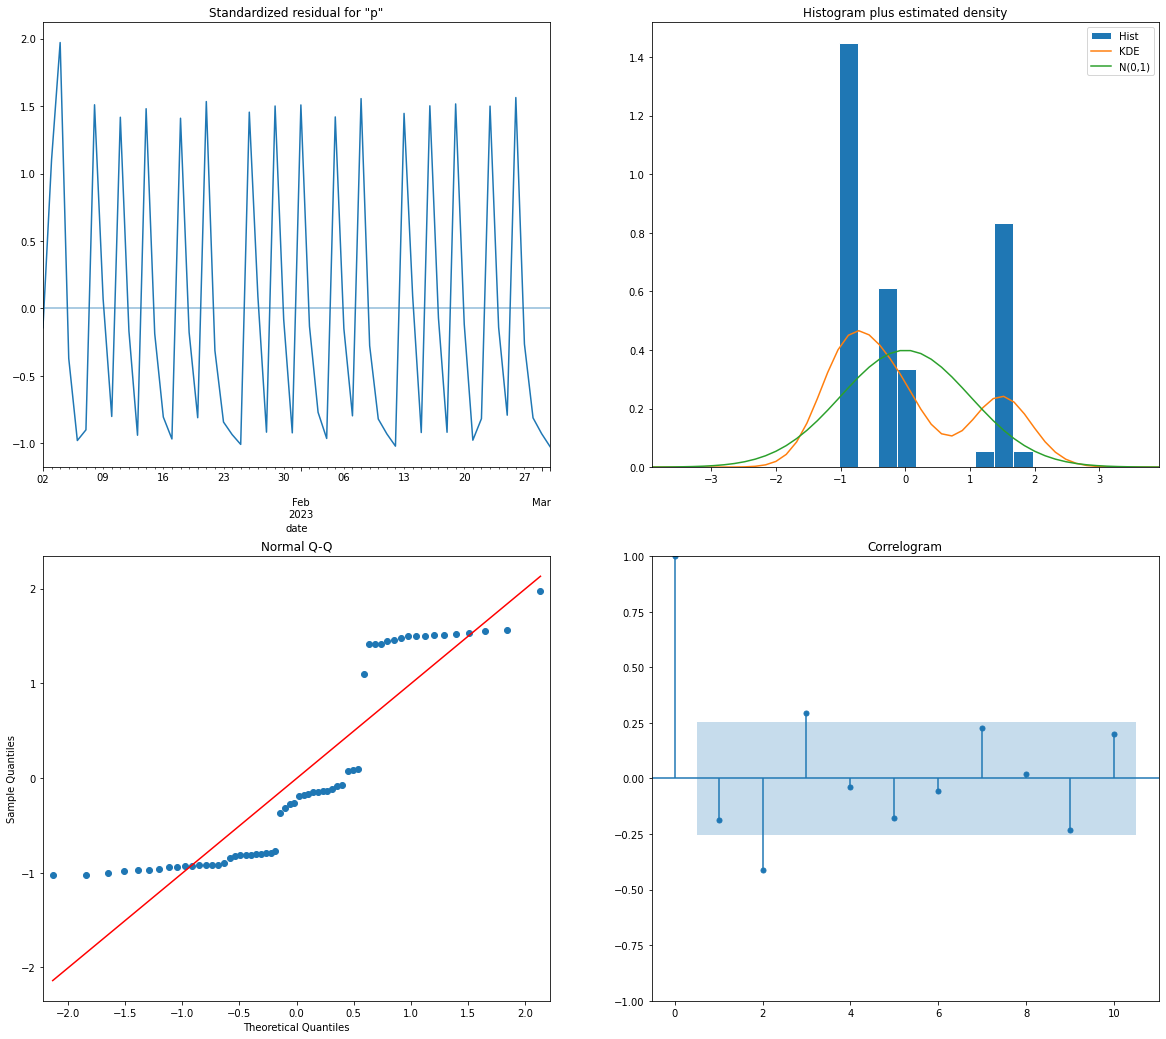

In [4]:
model_fit.plot_diagnostics(figsize=(20, 18))
plt.show()

## **Step 5: Tune the ARIMA Model**

In [5]:
p = d = q = range(0, 3)
pdq_combinations = list(itertools.product(p, d, q))

best_aic = np.inf
best_p = None
best_d = None
best_q = None
best_model = None

for combination in pdq_combinations:
    try:
        model = ARIMA(daily_sales, order=combination)
        model_fit = model.fit()       
        if model_fit.aic < best_aic:
            best_aic = model_fit.aic
            best_p = combination[0]
            best_d = combination[1]
            best_q = combination[2]
            best_model = model_fit
            
    except:
        continue

print(f"Best ARIMA{best_p, best_d, best_q} - AIC:{best_aic}")

Best ARIMA(2, 0, 2) - AIC:834.8630577801448


## **Step 6: Forecast Future Sales**

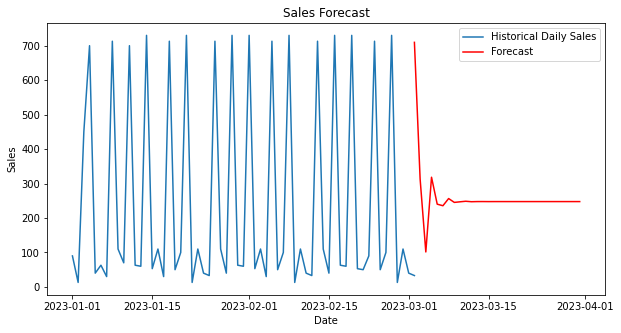

In [6]:
# Using the best model from tuning step
best_model = ARIMA(daily_sales, order=(best_p, best_d, best_q))
best_model_fit = best_model.fit()

# Forecast
forecast = best_model_fit.forecast(steps=30)

# Plotting the forecast
plt.figure(figsize=(10, 5))
plt.plot(daily_sales.index, daily_sales, label='Historical Daily Sales')
plt.plot(pd.date_range(daily_sales.index[-1], periods=30, freq='D'), forecast, label='Forecast', color='red')
plt.title('Sales Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()